## Sales Forecasting for Rossmann Store
    -> Using Internal, Competitor, Promotional Data

In [148]:
# Prophet Packages
from fbprophet import Prophet

# Computational Packages
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF

# Visualisational Packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Ignoring warning
import warnings
warnings.filterwarnings('ignore')

In [149]:
# Loading the store data
additional_store = pd.read_csv('data/rossman_store/store.csv')
sales_data = pd.read_csv('data/rossman_store/train.csv', parse_dates = True, index_col = 'Date')
test_data = pd.read_csv('data/rossman_store/test.csv',  parse_dates = True, index_col = 'Date')

print ("Shape of the training data = ", sales_data.shape)
print ("Shape of the test data = ", test_data.shape)

('Shape of the training data = ', (1017209, 8))
('Shape of the test data = ', (41088, 7))


In [151]:
print ("--- Sample Sales Data ---")
sales_data.head()

--- Sample Sales Data ---


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [152]:
print ("--- Additional Store Data ---")
additional_store.head()

--- Additional Store Data ---


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Formatting and Initial Data Cleansing

In [153]:
# Facilitating preprocessing by extracting Year, Month, Day, and WeekOfYear
sales_data['year'] = sales_data.index.year
sales_data['month'] = sales_data.index.month
sales_data['day'] = sales_data.index.day
sales_data['week_in_year'] = sales_data.index.weekofyear
sales_data['per_customer_sale'] = sales_data['Sales'] / sales_data['Customers']

# Descriptive Statistics on the sales, customers, per_customer_sale columns
print ("--- Descriptive Stats on Training Data----")
sales_data[['Sales', 'Customers', 'per_customer_sale']].describe()

--- Descriptive Stats on Training Data----


,Sales,Customers,per_customer_sale
count,1.017209e+06,1.017209e+06,844340.000000
mean,5.773819e+03,6.331459e+02,9.493619
std,3.849926e+03,4.644117e+02,2.197494
min,0.000000e+00,0.000000e+00,0.000000
25%,3.727000e+03,4.050000e+02,7.895563
50%,5.744000e+03,6.090000e+02,9.250000
75%,7.856000e+03,8.370000e+02,10.899729
max,4.155100e+04,7.388000e+03,64.957854


In [154]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
Store                1017209 non-null int64
DayOfWeek            1017209 non-null int64
Sales                1017209 non-null int64
Customers            1017209 non-null int64
Open                 1017209 non-null int64
Promo                1017209 non-null int64
StateHoliday         1017209 non-null object
SchoolHoliday        1017209 non-null int64
year                 1017209 non-null int64
month                1017209 non-null int64
day                  1017209 non-null int64
week_in_year         1017209 non-null int64
per_customer_sale    844340 non-null float64
dtypes: float64(1), int64(11), object(1)
memory usage: 128.6+ MB


In [155]:
# Dropping closed stores and zero sales stores to avoid introduce any bias to the predictions
sales_data = sales_data[(sales_data['Open'] != 0) & (sales_data['Sales'] != 0)]
print ("New shape of the training data = ", sales_data.shape)

# Cleaning additional store dataset
print ("\n -- Identifying null values in the store datasets -- \n")
print (additional_store.isnull().sum())

#Replacing missing CompetitionDistance values with mean
additional_store['CompetitionDistance'].\
fillna(additional_store['CompetitionDistance'].mean(), inplace = True) 

additional_store.fillna(0, inplace=True)

print ("New shape of the store-information dataset = ", additional_store.shape)
print ("\n -- Summary Stats on the store-information dataset --")
additional_store.describe()

('New shape of the training data = ', (844338, 13))

 -- Identifying null values in the store datasets -- 

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
('New shape of the store-information dataset = ', (1115, 10))

 -- Summary Stats on the store-information dataset --


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5404.901079,4.930942,1370.939013,0.512108,12.083408,1030.239462
std,322.01708,7652.849306,4.284924,935.467654,0.500078,15.542241,1006.038782
min,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,720.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,2330.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [156]:
# Expanding training set to include additional store information

sales_data_expanded = pd.merge(sales_data, additional_store, how='inner', on='Store')
sales_data_expanded['CompetitionOpen'] = 12 * (sales_data_expanded.year - sales_data_expanded.CompetitionOpenSinceYear)\
 + (sales_data_expanded.month - sales_data_expanded.CompetitionOpenSinceMonth) 

sales_data_expanded['PromoOpen'] = 12 * (sales_data_expanded.year - sales_data_expanded.Promo2SinceYear) + \
(sales_data_expanded.week_in_year - sales_data_expanded.Promo2SinceWeek) / 4.0

sales_data_expanded.fillna(0, inplace=True)

sales_data_expanded.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


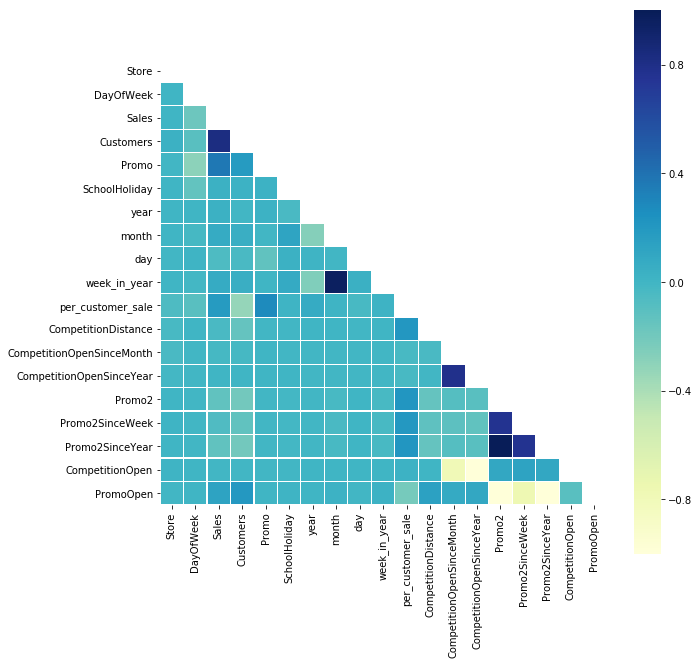

In [157]:
# Understanding correlations
sales_data_expanded_corr = sales_data_expanded.drop('Open', axis=1).corr()

hide_zone = np.zeros_like(sales_data_expanded_corr, dtype=np.bool)
hide_zone[np.triu_indices_from(hide_zone)] = True

fig, axes = plt.subplots(figsize=(10,10))
sns.heatmap(sales_data_expanded_corr, mask=hide_zone, square=True, linewidths=.4, ax=axes, cmap = "YlGnBu")

## Understanding customer trends


 -- Customer Trends -- 



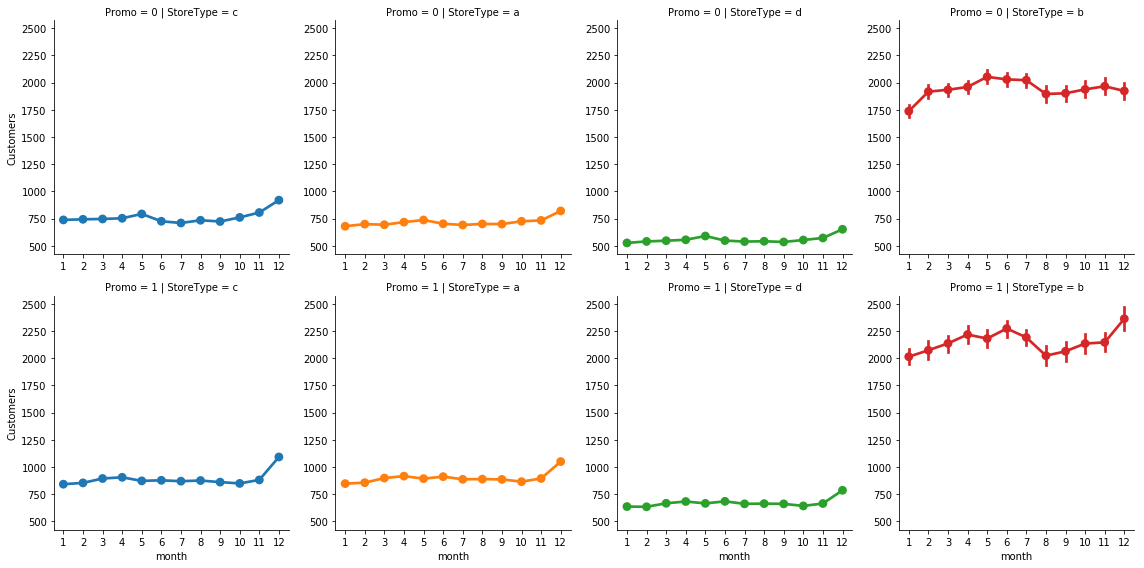

In [158]:
print ("\n -- Customer Trends -- \n")
sns.factorplot(data=sales_data_expanded, x='month', y='Customers', col='StoreType', hue='StoreType',
              row='Promo')


 -- Sales Trend -- 



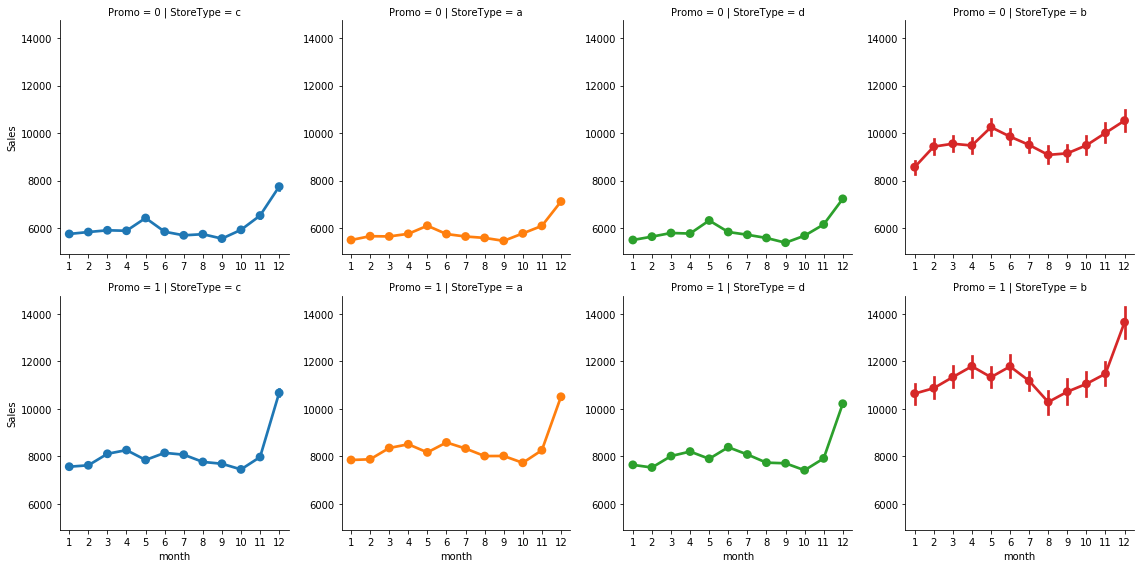

In [159]:
print ("\n -- Sales Trend -- \n")
sns.factorplot(data=sales_data_expanded, x='month', y='Sales', col='StoreType', hue='StoreType',
              row='Promo')


 -- Sales per customer Trends -- 



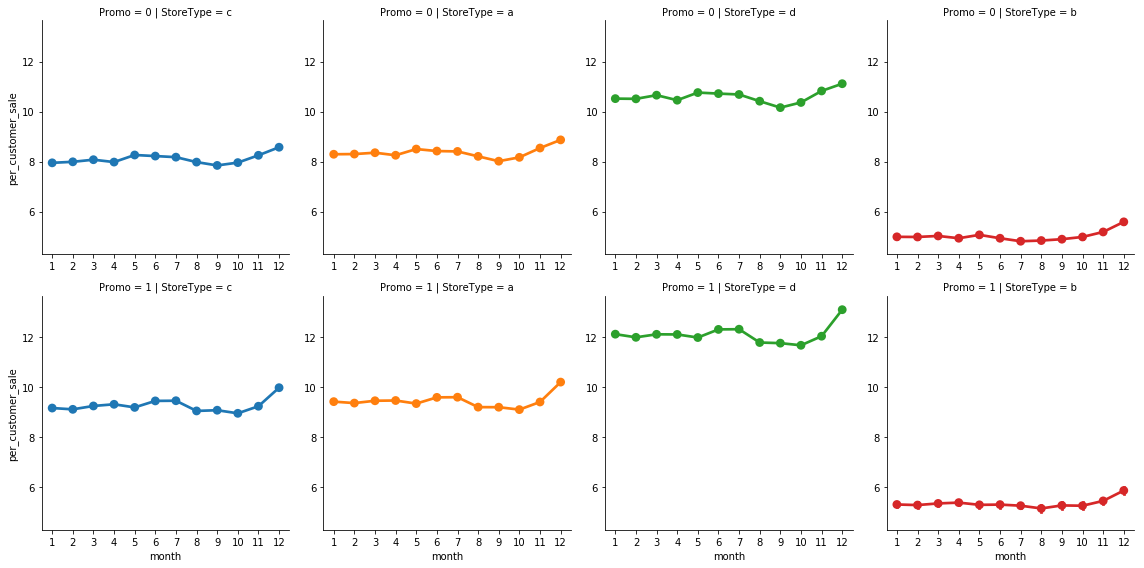

In [160]:
print ("\n -- Sales per customer Trends -- \n")
sns.factorplot(data=sales_data_expanded, x='month', y='per_customer_sale', col='StoreType', hue='StoreType',
              row='Promo')

## Predictions using Prophet package

In [161]:
sales_data = pd.read_csv('data/rossman_store/train.csv')
sales_data = sales_data[(sales_data['Open'] !=0) & (sales_data['Sales'] !=0)]
sales_data = sales_data[sales_data.Store == 1].loc[:, ['Date', 'Sales']]
sales_data = sales_data.sort_index(ascending = False)
sales_data['Date'] = pd.DatetimeIndex(sales_data['Date'])
sales_data = sales_data.rename(columns={'Date':'ds', 'Sales':'y'})

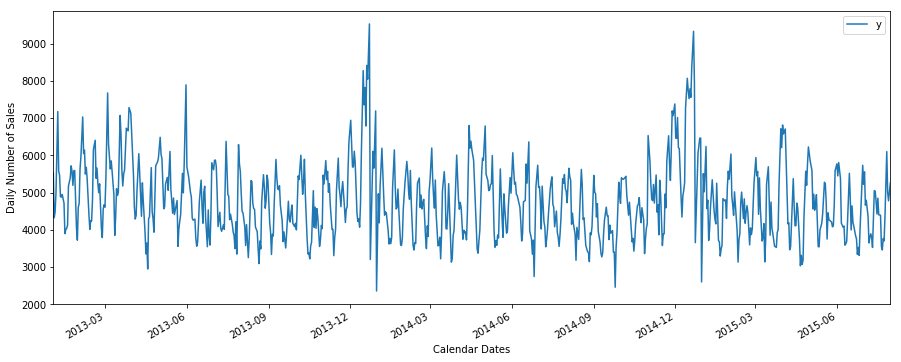

In [162]:
# Understanding Daily Sales
ax = sales_data.set_index('ds').plot(figsize = (15, 6))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Calendar Dates')
plt.show()

In [163]:
# Creating a Prophet model
prophet_model = Prophet(interval_width=0.96)
prophet_model.fit(sales_data)
upcoming_dates = prophet_model.make_future_dataframe(periods=6*7)
predictions = prophet_model.predict(upcoming_dates)
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(20)

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-02,5560.509110,3766.313813,7287.528406
1,2013-01-03,5341.116382,3753.086181,7172.300093
2,2013-01-04,5471.288410,3900.413716,7058.035664
3,2013-01-05,5559.149086,3823.493477,7244.692161
4,2013-01-07,5587.378009,3913.608728,7264.124806
5,2013-01-08,5007.085039,3310.231923,6767.487013
6,2013-01-09,4811.375857,3251.030719,6413.573612
7,2013-01-10,4654.622106,3044.844097,6398.596285
8,2013-01-11,4853.507705,3239.578976,6502.744481
9,2013-01-12,5014.768558,3355.308574,6805.829865


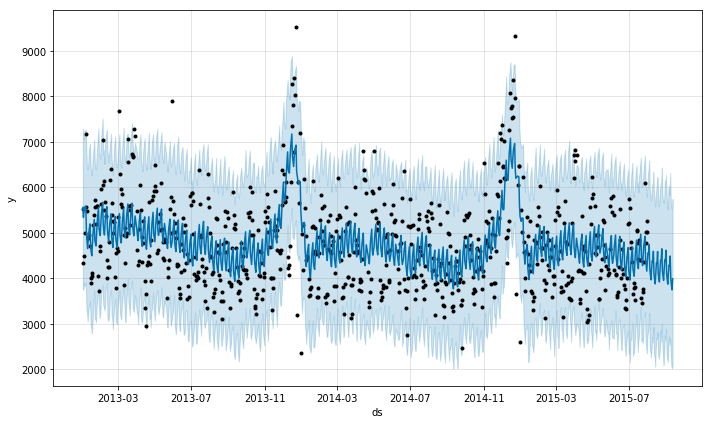

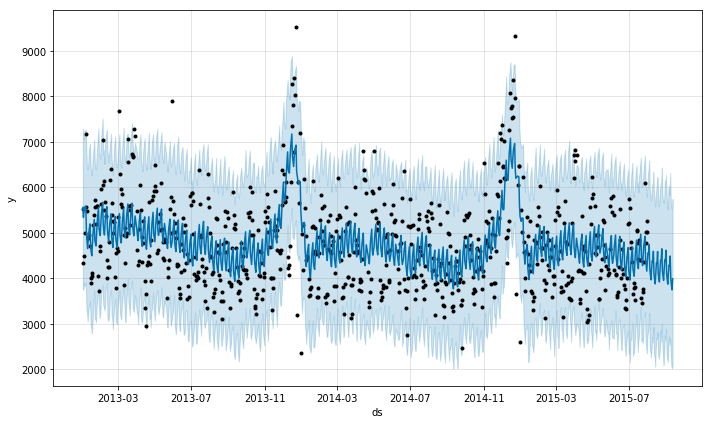

In [164]:
prophet_model.plot(predictions)

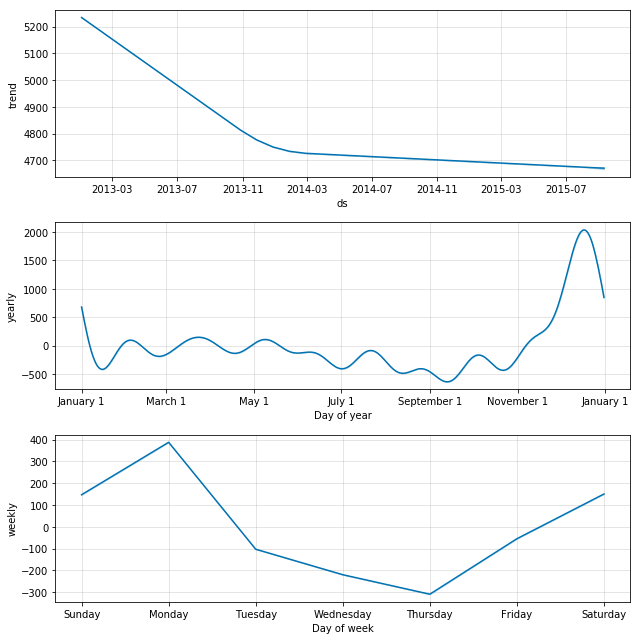

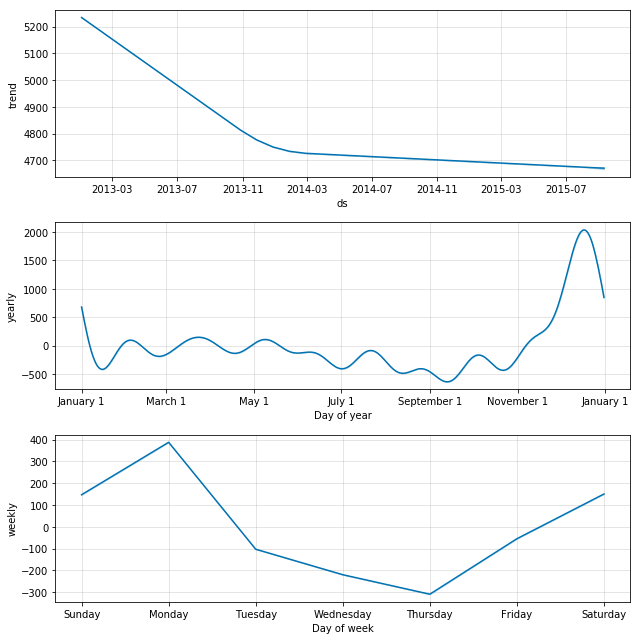

In [165]:
prophet_model.plot_components(predictions)